In [60]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib import cm
from matplotlib.lines import Line2D
import matplotlib.lines as mlines


import time
from numpy.random import default_rng

import healpy as hp
from healpy.newvisufunc import projview, newprojplot
import pandas as pd

import astropy.cosmology
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks
import maps

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Parameter setting

Plot formatting

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

Saving

In [3]:
plot_dir = '../plots/2023-03-26_figures'
save = False

Names

In [4]:
name_catalog = '\emph{{Gaia}} Cosmological Quasar Catalog'
abbrv_catalog = 'GaiaQ'

name_gpurer = '\emph{{Gaia}} Purer Sample'
abbrv_gpurer = '\emph{{Gaia}} Purer'

Plotting variables

In [94]:
cmap_map = 'plasma'
cmap_blues = utils.shiftedColorMap(matplotlib.cm.Blues, start=0.2, midpoint=0.6, stop=1.0)
cmap_hist = 'inferno_r'

Functions

In [6]:
def get_ndens_map(ras, decs, NSIDE=64):
    map_nqso, _ = maps.get_map(NSIDE, ras, decs, null_val=0)
    map_ndens = map_nqso/area_per_pixel
    map_ndens_masked = hp.ma(map_ndens)
    map_ndens_masked.mask = map_ndens==0
    return map_ndens_masked

Map settings

In [7]:
NSIDE = 64
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

Area per pixel: 0.839 deg


Other prelims

In [8]:
G_hi = 20.5
G_lo = 20.0

In [35]:
rng = np.random.default_rng(seed=42)

# Load datasets

### Gaia

In [9]:
fn_gall = '../data/gaia_candidates.fits.gz'
tab_gall = utils.load_table(fn_gall)
print(len(tab_gall))

6649162


In [10]:
fn_gpurer_ids = '../data/gaia_purer_sourceids.fits'
tab_gpurer_ids = utils.load_table(fn_gpurer_ids)
tab_gpurer = join(tab_gall, tab_gpurer_ids, keys='source_id', join_type='inner', metadata_conflicts='silent')
print(len(tab_gpurer))

1942825


In [11]:
fn_gsup = '../data/gaia_candidates_superset.fits'
tab_gsup = utils.load_table(fn_gsup)
print(len(tab_gsup))

1518782


In [12]:
fn_gclean = '../data/gaia_candidates_clean.fits'
tab_gclean = utils.load_table(fn_gclean)
print(len(tab_gclean))

1437229


### SDSS

These are SDSS objects that have (any) Gaia source matches. There is unWISE data where available, but the below catalogs are not limited to unWISE matches.

In [21]:
tab_squasars = utils.load_table(f'../data/quasars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS quasars: {len(tab_squasars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_squasars['mag_w1_vg']) & ~tab_squasars.mask['mag_w1_vg']))

Number of SDSS quasars: 379698
Number with unWISE info: 350070


In [22]:
tab_sstars = utils.load_table(f'../data/stars_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS stars: {len(tab_sstars)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sstars['mag_w1_vg']) & ~tab_sstars.mask['mag_w1_vg']))

Number of SDSS stars: 683221
Number with unWISE info: 482080


In [23]:
tab_sgals = utils.load_table(f'../data/galaxies_sdss_xgaia_xunwise_good_nodup.fits')
print(f"Number of SDSS galaxies: {len(tab_sgals)}")
print(f"Number with unWISE info:", np.sum(np.isfinite(tab_sgals['mag_w1_vg']) & ~tab_sgals.mask['mag_w1_vg']))

Number of SDSS galaxies: 717059
Number with unWISE info: 600897


Only objects in superset (gaia qso candidates with unWISE data and QSOC redshifts and G lim)

In [27]:
fn_labeled_sup = '../data/labeled_superset.fits'
tab_labeled_sup = utils.load_table(fn_labeled_sup)
print(f"Number of labeled Gaia quasar candidates for training/validation: {len(tab_labeled_sup)}")

Number of labeled Gaia quasar candidates for training/validation: 249714


# Figures

### Purer map

TODO: should i limit to having QSOC redshifts here? (now just do G lim)

TODO: healpy / matplotlib error with show_tickmarkers=True

In [ ]:
i_Ghi = tab_gpurer['phot_g_mean_mag'] < G_hi

map_gpurer = get_ndens_map(tab_gpurer['ra'][i_Ghi], tab_gpurer['dec'][i_Ghi], NSIDE=NSIDE)

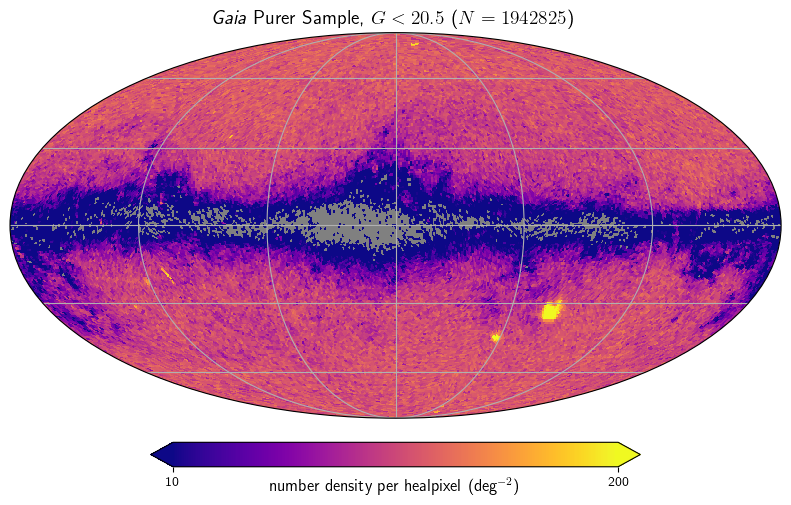

In [20]:
projview(map_gpurer, title=rf"{name_gpurer}, $G<{G_hi}$ ($N={len(tab_gpurer)}$)",
            unit=r"number density per healpixel (deg$^{-2}$)", cmap=cmap_map, coord=['C', 'G'], 
            min=10, max=200, norm='log', graticule=True,
            #show_tickmarkers=True
        )

### Decontamination

In [32]:
tag_decontam = '_mag0.1-0.01'
#tag_decontam = '_mag0.1'
fn_cuts = f'../data/color_cuts{tag_decontam}.txt'
color_names, cuts = np.genfromtxt(fn_cuts, dtype=['U15', '<f8'], unpack=True)

In [ ]:
# cut_0, cut_1 = [0, 1, g_w1_vals[i_best]], [1, 0, bp_g_vals[k_best]]
# x_eq = (cut_0[2]*cut_1[1] - cut_1[2]*cut_0[1])/(cut_0[0]*cut_1[1] - cut_1[0]*cut_0[1])
# y_eq = (cut_0[2]*cut_1[0] - cut_1[2]*cut_0[0])/(cut_0[1]*cut_1[0] - cut_1[1]*cut_0[0])

In [71]:
g_w1_lim = (-1, 9)
w1_w2_lim = (-1, 2)
bp_g_lim = (-4, 3)
g_rp_lim = (-1, 6)
#bins_x = np.linspace(*x_lim, 100)
#bins_y = np.linspace(*y_lim, 100)

In [ ]:
tabs = [tab_squasars, tab_sstars, tab_sgals]

In [ ]:
colors = ['blue', 'brown', 'orange']
labels = ['SDSS Quasars', 'SDSS Stars', 'SDSS Galaxies']
zorders = [1,2,3]

(-1.0, 6.0)

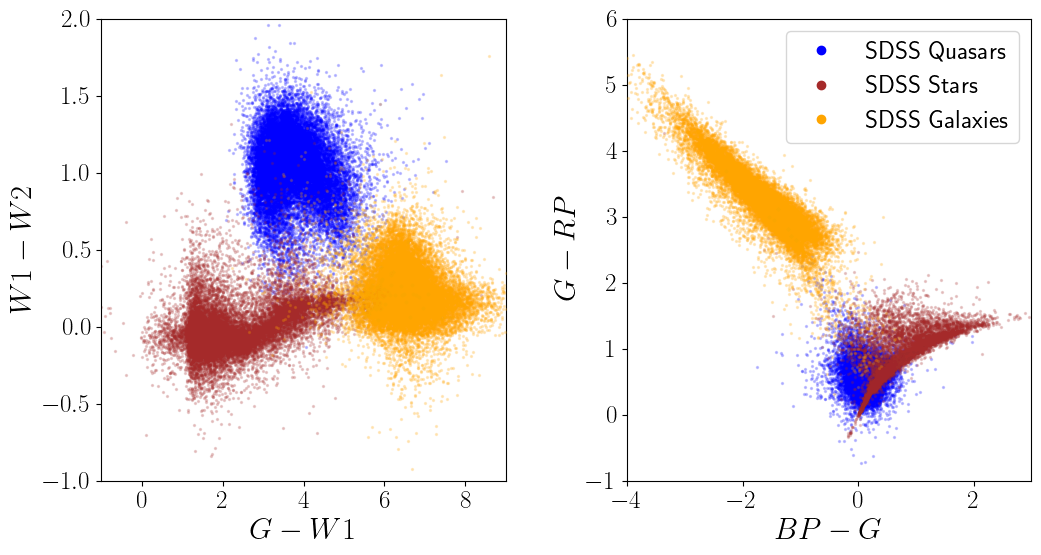

In [72]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

N_subsample = 20000
patches = []

# plot_cut(ax, cut_0, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='x')
# plot_cut(ax, cut_1, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='y')

for i in range(len(tabs)):
    tab = tabs[i]
    i_unwise = np.isfinite(tab['mag_w1_vg']) & np.isfinite(tab['mag_w2_vg'])
    i_subsample = rng.choice(np.arange(len(tab[i_unwise])), size=N_subsample, replace=False)
    tab_plot = tab[i_unwise][i_subsample]
    
        
    ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
    
    ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
                        
    patches.append( mlines.Line2D([], [], ls='None', color=colors[i], label=labels[i], marker='o'))

ax1.legend(handles=patches, loc='upper right')

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

In [74]:
tab_q = tab_labeled_sup[tab_labeled_sup['class']=='q']
tab_s = tab_labeled_sup[tab_labeled_sup['class']=='s']
tab_g = tab_labeled_sup[tab_labeled_sup['class']=='g']

In [77]:
tabs = [tab_s, tab_g]
colors = ['brown', 'orange']
labels = ['SDSS Stars', 'SDSS Galaxies']
zorders = [1,2]

(-1.0, 6.0)

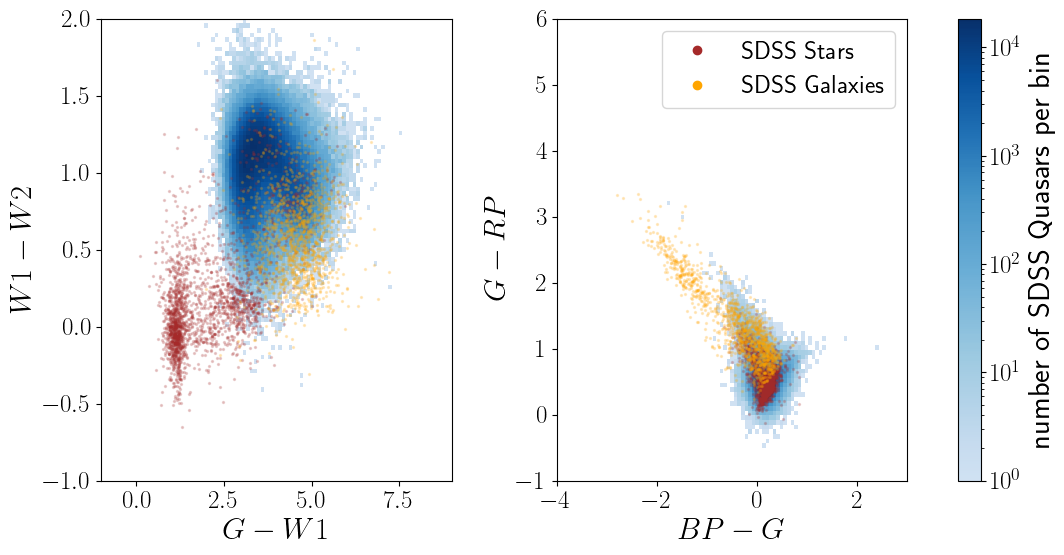

In [100]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

#N_subsample = 20000
patches = []

# plot_cut(ax, cut_0, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='x')
# plot_cut(ax, cut_1, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='y')
cmax = 5e4
    
bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

g_w1 = np.array(tab_q['phot_g_mean_mag']-tab_q['mag_w1_vg'])
w1_w2 = np.array(tab_q['mag_w1_vg']-tab_q['mag_w2_vg'])
h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmax=cmax, cmap=cmap_blues, norm='log')

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

bp_g = np.array(tab_q['phot_bp_mean_mag']-tab_q['phot_g_mean_mag'])
g_rp = np.array(tab_q['phot_g_mean_mag']-tab_q['phot_rp_mean_mag'])
h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmax=cmax, cmap=cmap_blues, norm='log')

fig.colorbar(h[3], ax=axarr.ravel().tolist(), label='number of SDSS Quasars per bin')

for i in range(len(tabs)):
    tab_plot = tabs[i]

    ax0.scatter(tab_plot['phot_g_mean_mag']-tab_plot['mag_w1_vg'], 
                tab_plot['mag_w1_vg']-tab_plot['mag_w2_vg'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
    
    ax1.scatter(tab_plot['phot_bp_mean_mag']-tab_plot['phot_g_mean_mag'], 
                tab_plot['phot_g_mean_mag']-tab_plot['phot_rp_mean_mag'],
                color=colors[i], alpha=0.2, s=2, zorder=zorders[i])
                        
    patches.append( mlines.Line2D([], [], ls='None', color=colors[i], label=labels[i], marker='o'))

ax1.legend(handles=patches, loc='upper right')

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)

(-1.0, 6.0)

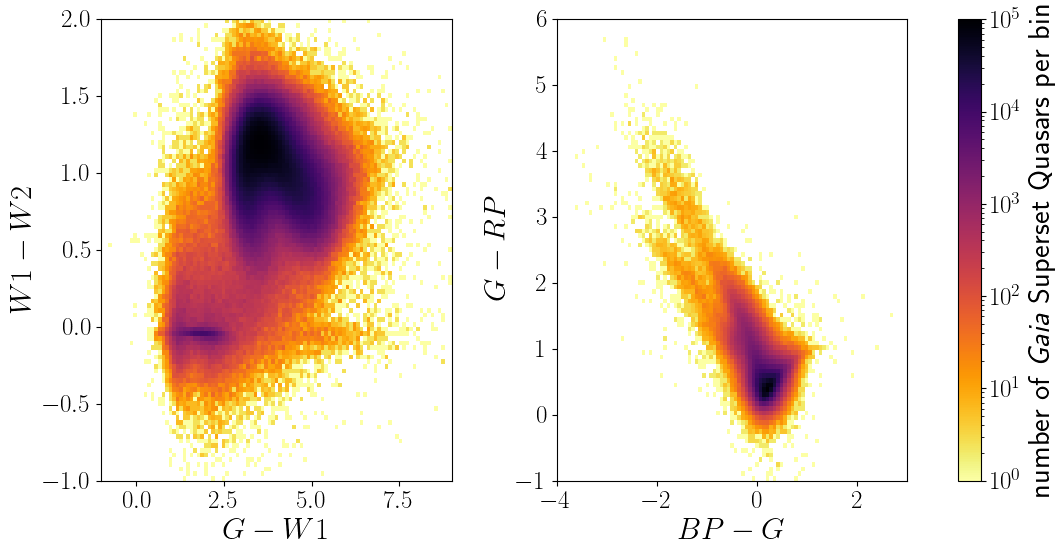

In [101]:
fig, axarr = plt.subplots(nrows=1, ncols=2, figsize=(13,6))
ax0, ax1 = axarr
plt.subplots_adjust(wspace=0.3)

# plot_cut(ax, cut_0, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='x')
# plot_cut(ax, cut_1, x_eq=x_eq, y_eq=y_eq, only_plot='above', only_axis='y')
    
bins_g_w1 = np.linspace(*g_w1_lim, 100)
bins_w1_w2 = np.linspace(*w1_w2_lim, 100)

g_w1 = np.array(tab_gsup['phot_g_mean_mag']-tab_gsup['mag_w1_vg'])
w1_w2 = np.array(tab_gsup['mag_w1_vg']-tab_gsup['mag_w2_vg'])
h = ax0.hist2d(g_w1, w1_w2, bins=(bins_g_w1, bins_w1_w2), cmin=1, cmap=cmap_hist, norm='log')

bins_bp_g = np.linspace(*bp_g_lim, 100)
bins_g_rp = np.linspace(*g_rp_lim, 100)

bp_g = np.array(tab_gsup['phot_bp_mean_mag']-tab_gsup['phot_g_mean_mag'])
g_rp = np.array(tab_gsup['phot_g_mean_mag']-tab_gsup['phot_rp_mean_mag'])
h = ax1.hist2d(bp_g, g_rp, bins=(bins_bp_g, bins_g_rp), cmin=1, cmap=cmap_hist, norm='log')

fig.colorbar(h[3], ax=axarr.ravel().tolist(), label=r'number of \emph{Gaia} Superset Quasars per bin')

ax0.set_xlabel(r'$G-W1$')
ax0.set_ylabel(r'$W1-W2$')
ax0.set_xlim(g_w1_lim)
ax0.set_ylim(w1_w2_lim)

ax1.set_xlabel(r'$BP-G$')
ax1.set_ylabel(r'$G-RP$')
ax1.set_xlim(bp_g_lim)
ax1.set_ylim(g_rp_lim)